# Fuzzy Neural Network

In [1]:
from yield_prediction_system import YieldPredictionSystem

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import copy

pd.set_option('display.max_columns', None)

In [2]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [3]:
T_NORM = 'product'
T_CONORM = 'sum'

In [4]:
df_fnn = pd.read_csv('../data/rice-yield-clean-data.csv')
df_fnn.head()

,panicle,growth,yield
0,3.975,184.0,7.5000
1,3.975,184.0,6.7500
2,2.850,125.0,6.4275
3,4.500,147.5,7.2285
4,5.100,167.5,8.7150


In [5]:
fuzzy_system_fnn = YieldPredictionSystem(data=df_fnn, t_norm=T_NORM, t_conorm=T_CONORM)

In [6]:
# Checking if everything is loaded correctly
print(fuzzy_system_fnn.panicle_datapoints)
print(fuzzy_system_fnn.growth_datapoints)
print(fuzzy_system_fnn.yield_datapoints)
print(fuzzy_system_fnn.t_norm.__name__, fuzzy_system_fnn.t_conorm.__name__)

{'min': 2.55, 'pct10': 2.895, 'pct25': 3.06375, 'pct50': 3.3075, 'pct75': 3.75, 'pct90': 4.295999999999999, 'max': 5.115}
{'min': 123.4, 'pct10': 135.0, 'pct25': 142.0, 'pct50': 154.0, 'pct75': 160.72500000000002, 'pct90': 175.97, 'max': 191.5}
{'min': 6.4011, 'pct10': 7.71381, 'pct25': 8.403375, 'pct50': 8.855699999999999, 'pct75': 9.41925, 'pct90': 10.099499999999999, 'max': 11.19}
t_norm_product t_conorm_sum


## Fuzzification

In [7]:
# Fuzzify the input data
fuzzy_system_fnn.fuzzify_input()
fuzzy_system_fnn.data.head()

,panicle,growth,yield,VLP,LP,MP,HP,VHP,VLG,LG,MG,HG,VHG
0,3.975,184.0,7.5000,0.0,0.0,0.0,0.587912,0.412088,0.0,0.000000,0.000000,0.000000,1.000000
1,3.975,184.0,6.7500,0.0,0.0,0.0,0.587912,0.412088,0.0,0.000000,0.000000,0.000000,1.000000
2,2.850,125.0,6.4275,1.0,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
3,4.500,147.5,7.2285,0.0,0.0,0.0,0.000000,1.000000,0.0,0.541667,0.458333,0.000000,0.000000
4,5.100,167.5,8.7150,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.555592,0.444408


In [8]:
# Fuzzify the output data
fuzzy_system_fnn.data['real_VLY'] = fuzzy_system_fnn.data['yield'].apply(fuzzy_system_fnn.mu_VLY)
fuzzy_system_fnn.data['real_LY'] = fuzzy_system_fnn.data['yield'].apply(fuzzy_system_fnn.mu_LY)
fuzzy_system_fnn.data['real_MY'] = fuzzy_system_fnn.data['yield'].apply(fuzzy_system_fnn.mu_MY)
fuzzy_system_fnn.data['real_HY'] = fuzzy_system_fnn.data['yield'].apply(fuzzy_system_fnn.mu_HY)
fuzzy_system_fnn.data['real_VHY'] = fuzzy_system_fnn.data['yield'].apply(fuzzy_system_fnn.mu_VHY)

fuzzy_system_fnn.data.head()

,panicle,growth,yield,VLP,LP,MP,HP,VHP,VLG,LG,MG,HG,VHG,real_VLY,real_LY,real_MY,real_HY,real_VHY
0,3.975,184.0,7.5000,0.0,0.0,0.0,0.587912,0.412088,0.0,0.000000,0.000000,0.000000,1.000000,1.0,0.00000,0.00000,0.0,0.0
1,3.975,184.0,6.7500,0.0,0.0,0.0,0.587912,0.412088,0.0,0.000000,0.000000,0.000000,1.000000,1.0,0.00000,0.00000,0.0,0.0
2,2.850,125.0,6.4275,1.0,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.0,0.00000,0.00000,0.0,0.0
3,4.500,147.5,7.2285,0.0,0.0,0.0,0.000000,1.000000,0.0,0.541667,0.458333,0.000000,0.000000,1.0,0.00000,0.00000,0.0,0.0
4,5.100,167.5,8.7150,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.555592,0.444408,0.0,0.31106,0.68894,0.0,0.0


In [9]:
# Include negations of the fuzzy sets
not_mu = lambda x: 1 - x

fuzzy_system_fnn.data['not_VLP'] = fuzzy_system_fnn.data['VLP'].apply(not_mu)
fuzzy_system_fnn.data['not_LP'] = fuzzy_system_fnn.data['LP'].apply(not_mu)
fuzzy_system_fnn.data['not_MP'] = fuzzy_system_fnn.data['MP'].apply(not_mu)
fuzzy_system_fnn.data['not_HP'] = fuzzy_system_fnn.data['HP'].apply(not_mu)
fuzzy_system_fnn.data['not_VHP'] = fuzzy_system_fnn.data['VHP'].apply(not_mu)

fuzzy_system_fnn.data['not_VLG'] = fuzzy_system_fnn.data['VLG'].apply(not_mu)
fuzzy_system_fnn.data['not_LG'] = fuzzy_system_fnn.data['LG'].apply(not_mu)
fuzzy_system_fnn.data['not_MG'] = fuzzy_system_fnn.data['MG'].apply(not_mu)
fuzzy_system_fnn.data['not_HG'] = fuzzy_system_fnn.data['HG'].apply(not_mu)
fuzzy_system_fnn.data['not_VHG'] = fuzzy_system_fnn.data['VHG'].apply(not_mu)

fuzzy_system_fnn.data.head()

,panicle,growth,yield,VLP,LP,MP,HP,VHP,VLG,LG,MG,HG,VHG,real_VLY,real_LY,real_MY,real_HY,real_VHY,not_VLP,not_LP,not_MP,not_HP,not_VHP,not_VLG,not_LG,not_MG,not_HG,not_VHG
0,3.975,184.0,7.5000,0.0,0.0,0.0,0.587912,0.412088,0.0,0.000000,0.000000,0.000000,1.000000,1.0,0.00000,0.00000,0.0,0.0,1.0,1.0,1.0,0.412088,0.587912,1.0,1.000000,1.000000,1.000000,0.000000
1,3.975,184.0,6.7500,0.0,0.0,0.0,0.587912,0.412088,0.0,0.000000,0.000000,0.000000,1.000000,1.0,0.00000,0.00000,0.0,0.0,1.0,1.0,1.0,0.412088,0.587912,1.0,1.000000,1.000000,1.000000,0.000000
2,2.850,125.0,6.4275,1.0,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.0,0.00000,0.00000,0.0,0.0,0.0,1.0,1.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000
3,4.500,147.5,7.2285,0.0,0.0,0.0,0.000000,1.000000,0.0,0.541667,0.458333,0.000000,0.000000,1.0,0.00000,0.00000,0.0,0.0,1.0,1.0,1.0,1.000000,0.000000,1.0,0.458333,0.541667,1.000000,1.000000
4,5.100,167.5,8.7150,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.555592,0.444408,0.0,0.31106,0.68894,0.0,0.0,1.0,1.0,1.0,1.000000,0.000000,1.0,1.000000,1.000000,0.444408,0.555592


In [10]:
X = fuzzy_system_fnn.data[['VLP', 'LP', 'MP', 'HP', 'VHP', 
                           'VLG', 'LG', 'MG', 'HG', 'VHG', 
                           'not_VLP', 'not_LP', 'not_MP', 'not_HP', 'not_VHP', 
                           'not_VLG', 'not_LG', 'not_MG', 'not_HG', 'not_VHG']].values
y = fuzzy_system_fnn.data[['real_VLY', 'real_LY', 'real_MY', 'real_HY', 'real_VHY']].values

X.shape, y.shape

((534, 20), (534, 5))

## Model

In [11]:
# --- Operators for the fuzzy neural network ---

# Note: these operators have been tested before using them here

if T_NORM == 'min':
    # t-norm for the AND layer, returns a vector
    t_norm_and_layer = lambda x: torch.min(x, dim=0).values    

    # t-norm for the OR layer, returns a matrix 
    t_norm_or_layer = lambda x, y: torch.min(x, y)             

if T_CONORM == 'max':
    # t-conorm for the AND layer, returns a matrix
    t_conorm_and_layer = lambda x, y: torch.max(x, y)   

    # t-conorm for the OR layer, returns a vector 
    t_conorm_or_layer = lambda x: torch.max(x, dim=0).values  


if T_NORM == 'product':
    # t-norm for the AND layer, returns a vector
    t_norm_and_layer = lambda x: torch.prod(x, dim=0)    

    # t-norm for the OR layer, returns a matrix
    t_norm_or_layer = lambda x, y: torch.mul(x, y)       

if T_CONORM == 'sum':
    # t-conorm for the AND layer, returns a matrix
    t_conorm_and_layer = lambda x, y: x + y - torch.mul(x, y)        
    
    # sum t-conorm
    t_conorm_sum = lambda x, y: x + y - torch.mul(x, y)         

    # t-conorm for the OR layer, returns a vector       
    def t_conorm_or_layer(x):                                          
        while True:
            if x.shape[0] == 1:
                x.reshape(-1)
                break
            elif x.shape[0] == 2:
                x = t_conorm_sum(x[0], x[1])
                x.reshape(-1)
                break
            else:
                x = torch.cat((torch.stack([t_conorm_sum(x[0][i], x[1][i]) for i in range(x.shape[1])]).reshape(1,-1), x[2:]))
        return x
        

if T_NORM == 'lukasiewicz':
    # lukaiewicz t-norm
    t_norm_lukasiewicz = lambda x, y: torch.max(torch.zeros(x.shape), x + y - 1)

    # t-norm for the AND layer, returns a vector
    def t_norm_and_layer(x):
        while True:
            if x.shape[0] == 1:
                x.reshape(-1)
                break
            elif x.shape[0] == 2:
                x = t_norm_lukasiewicz(x[0], x[1])
                x.reshape(-1)
                break
            else:
                x = torch.cat((torch.stack([t_norm_lukasiewicz(x[0][i], x[1][i]) for i in range(x.shape[1])]).reshape(1,-1), x[2:]))
        return x

    # t-norm for the OR layer, returns a matrix 
    t_norm_or_layer = lambda x, y: torch.max(torch.zeros(x.shape), x + y - 1)

if T_CONORM == 'lukasiewicz':
    # t-conorm for the AND layer, returns a matrix
    t_conorm_and_layer = lambda x, y: torch.min(torch.ones(x.shape), x + y)
    
    # lukasiewicz t-conorm
    t_conorm_lukasiewicz = lambda x, y: torch.min(torch.ones(x.shape), x + y)

    # t-conorm for the OR layer, returns a vector
    def t_conorm_or_layer(x):                                     
        while True:
            if x.shape[0] == 1:
                x.reshape(-1)
                break
            elif x.shape[0] == 2:
                x = t_conorm_lukasiewicz(x[0], x[1])
                x.reshape(-1)
                break
            else:
                x = torch.cat((torch.stack([t_conorm_lukasiewicz(x[0][i], x[1][i]) for i in range(x.shape[1])]).reshape(1,-1), x[2:]))
        return x

In [12]:
# --- And layers and Or layers ---

np.random.seed(2)
torch.manual_seed(2)

class AndLayer(nn.Module):
    """
    AND layer of the fuzzy neural network.
    """
    def __init__(self, in_units, out_units):
        """
        Initialize the layer.

        Args:
            in_units (int): Number of inputs
            out_units (int): Number of outputs
        """
        super().__init__()
        self.weight = nn.Parameter(torch.rand((in_units, out_units)))

    def forward(self, X):
        """
        Forward pass of the layer.

        Args:
            X (torch.Tensor): Input tensor of shape (in_units)
        
        Returns:
            torch.Tensor: Output tensor of shape (out_units)
        """

        with torch.no_grad():
            # reshape X to a matrix of shape (in_units, 1) (column vector)
            X = X.reshape(-1, 1)
            # repeat X along columns, so that every column is equal to previous X
            X = X.expand_as(self.weight)

        # t_conorm of weigths and X (this gives, for each column of weights, the 
        # t_conorm between the input X and the column of weights)
        OR_matrix = t_conorm_and_layer(X, self.weight)   

        # t_norm of each column of OR_matrix
        AND_vector = t_norm_and_layer(OR_matrix)     
        
        return AND_vector 

class OrLayer(nn.Module):
    """
    OR layer of the fuzzy neural network.
    """
    def __init__(self, in_units, out_units):
        """
        Initialize the layer.

        Args:
            in_units (int): Number of inputs
            out_units (int): Number of outputs
        """
        super().__init__()
        self.weight = nn.Parameter(torch.rand((in_units, out_units)))

    def forward(self, X):
        """
        Forward pass of the layer.

        Args:
            X (torch.Tensor): Input tensor of shape (in_units)

        Returns:
            torch.Tensor: Output tensor of shape (out_units)
        """

        with torch.no_grad():
            # reshape X to a matrix of shape (in_units, 1) (column vector)
            X = X.reshape(-1, 1)
            # repeat X along columns, so that every column is equal to previous X
            X = X.expand_as(self.weight)

        # t_norm of weigths and X (this gives, for each column of weights, the 
        # t_norm between the input X and the column of weights)
        AND_matrix = t_norm_or_layer(X, self.weight)    

        # t_conorm of each column of AND_matrix
        OR_vector = t_conorm_or_layer(AND_matrix)     

        return OR_vector
    

# --- Fuzzy Neural Network ---
    
# Note: the network is defined specifically for the use case of the rice yield 
# prediction shown in the text. The hyperparameters (number of layers, number of
# neurons per layer, input and output shape, etc.) can be changed to fit other use cases.


class FuzzyNeuralNetwork(nn.Module):
    """
    Fuzzy Neural Network.
    """
    def __init__(self):
        """
        Initialize the network.
        """
        super(FuzzyNeuralNetwork, self).__init__()
        self.l1 = AndLayer(20,20)
        self.l2 = OrLayer(20,10)
        self.l3 = OrLayer(10,5)

    def forward(self,x):
        """
        Forward pass of the network.

        Args:
            x (torch.Tensor): Input tensor of shape (20)

        Returns:
            torch.Tensor: Output tensor of shape (5)
        """
        out= self.l1(x)
        out= self.l2(out)
        out= self.l3(out)   

        return(out)


## Training and testing

In [13]:
model = FuzzyNeuralNetwork()
loss_function = nn.MSELoss()    # Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=0.1)  

In [14]:
print(model)

FuzzyNeuralNetwork(
  (l1): AndLayer()
  (l2): OrLayer()
  (l3): OrLayer()
)


In [15]:
# train-test split of the dataset based on time: first 80% entries are training data, last 20% are test data
X_train, X_test= np.split(X, [int(.8 *len(X))])
y_train, y_test= np.split(y, [int(.8 *len(y))])

# convert numpy arrays to torch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# parameters for training
n_epochs = 25

# save the best model for later analysis
best_mse = np.inf   # initialize to infinity
best_weights = None

# save losses for later visualization
test_losses = []
train_losses = []

# training loop
for epoch in range(n_epochs):
    model.train()
    epoch_train_losses = []

    with tqdm(total=len(X_train)) as bar:
        bar.set_description(f"Epoch {epoch+1}")
        for i in range(len(X_train)):
            # take a sample
            X_sample = X_train[i]
            y_sample = y_train[i]

            # forward pass
            y_pred = model(X_sample)
            loss = loss_function(y_pred, y_sample)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()
            
            # save loss for later visualization
            epoch_train_losses.append(float(loss))
            
            # print progress
            bar.update()
            

    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = torch.stack([model(X_test[i]) for i in range(X_test.shape[0])])
    test_loss = float(loss_function(y_pred, y_test))

    # save loss and best model
    mean_train_loss = np.mean(epoch_train_losses)
    train_losses.append(mean_train_loss)
    test_losses.append(test_loss)
    if test_loss < best_mse:
        best_mse = test_loss
        best_weights = copy.deepcopy(model.state_dict())

    last_mse = test_loss
    last_weights = copy.deepcopy(model.state_dict())
    
    print(f"Train loss: {mean_train_loss:.6f}")
    print(f"Test loss: {test_loss:.6f}")

  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.114160
Test loss: 0.094052


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.111967
Test loss: 0.092464


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.110527
Test loss: 0.091573


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.109569
Test loss: 0.091058


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.108901
Test loss: 0.090741


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.108415
Test loss: 0.090530


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.108046
Test loss: 0.090379


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.107760
Test loss: 0.090264


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.107532
Test loss: 0.090172


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.107348
Test loss: 0.090097


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.107198
Test loss: 0.090036


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.107075
Test loss: 0.089985


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.106974
Test loss: 0.089944


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.106889
Test loss: 0.089910


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.106819
Test loss: 0.089882


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.106759
Test loss: 0.089860


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.106709
Test loss: 0.089843


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.106667
Test loss: 0.089830


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.106630
Test loss: 0.089820


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.106599
Test loss: 0.089814


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.106572
Test loss: 0.089809


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.106548
Test loss: 0.089807


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.106527
Test loss: 0.089806


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.106508
Test loss: 0.089807


  0%|          | 0/427 [00:00<?, ?it/s]

Train loss: 0.106492
Test loss: 0.089809


## Results

Best MSE: 0.089806
Last MSE: 0.089809


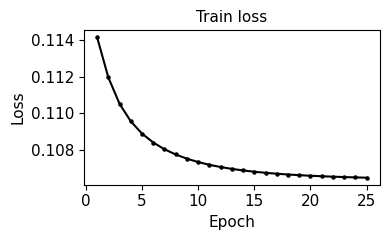

In [18]:
# Analysis of the results
print("Best MSE: %.6f" % best_mse)
print("Last MSE: %.6f" % last_mse)

# plot train losses
plt.figure(figsize=(4,2.5))

plt.plot(range(1,len(train_losses)+1), train_losses, color='black')
plt.scatter(range(1,len(train_losses)+1), train_losses, marker='o', s=5, color='black')

plt.title('Train loss', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()

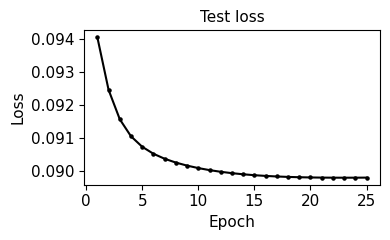

In [19]:
# plot test losses
plt.figure(figsize=(4,2.5))

plt.plot(range(1,len(test_losses)+1), test_losses, color='black')
plt.scatter(range(1,len(test_losses)+1), test_losses, marker='o', s=5, color='black')

plt.title('Test loss', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()

## Defuzzification

Predict crisp yield for all dataset, and select test data to analyze the results.

In [22]:
model.load_state_dict(last_weights)

y_pred_train = torch.stack([model(X_train[i]) for i in range(X_train.shape[0])])
y_pred_test = torch.stack([model(X_test[i]) for i in range(X_test.shape[0])])
# concatenate
y_pred = torch.cat((y_pred_train, y_pred_test))

# Add predicted membership values to the dataset
fuzzy_system_fnn.data['pred_VLY'] = y_pred[:,0].detach().numpy()
fuzzy_system_fnn.data['pred_LY'] = y_pred[:,1].detach().numpy()
fuzzy_system_fnn.data['pred_MY'] = y_pred[:,2].detach().numpy()
fuzzy_system_fnn.data['pred_HY'] = y_pred[:,3].detach().numpy()
fuzzy_system_fnn.data['pred_VHY'] = y_pred[:,4].detach().numpy()

In [23]:
fuzzy_system_fnn.data.head()

,panicle,growth,yield,VLP,LP,MP,HP,VHP,VLG,LG,MG,HG,VHG,real_VLY,real_LY,real_MY,real_HY,real_VHY,not_VLP,not_LP,not_MP,not_HP,not_VHP,not_VLG,not_LG,not_MG,not_HG,not_VHG,pred_VLY,pred_LY,pred_MY,pred_HY,pred_VHY
0,3.975,184.0,7.5000,0.0,0.0,0.0,0.587912,0.412088,0.0,0.000000,0.000000,0.000000,1.000000,1.0,0.00000,0.00000,0.0,0.0,1.0,1.0,1.0,0.412088,0.587912,1.0,1.000000,1.000000,1.000000,0.000000,0.208716,0.257209,0.362847,0.171780,0.397926
1,3.975,184.0,6.7500,0.0,0.0,0.0,0.587912,0.412088,0.0,0.000000,0.000000,0.000000,1.000000,1.0,0.00000,0.00000,0.0,0.0,1.0,1.0,1.0,0.412088,0.587912,1.0,1.000000,1.000000,1.000000,0.000000,0.208716,0.257209,0.362847,0.171780,0.397926
2,2.850,125.0,6.4275,1.0,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.0,0.00000,0.00000,0.0,0.0,0.0,1.0,1.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.097251,0.107301,0.152382,0.042549,0.057585
3,4.500,147.5,7.2285,0.0,0.0,0.0,0.000000,1.000000,0.0,0.541667,0.458333,0.000000,0.000000,1.0,0.00000,0.00000,0.0,0.0,1.0,1.0,1.0,1.000000,0.000000,1.0,0.458333,0.541667,1.000000,1.000000,0.106028,0.182203,0.273492,0.118020,0.149078
4,5.100,167.5,8.7150,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.555592,0.444408,0.0,0.31106,0.68894,0.0,0.0,1.0,1.0,1.0,1.000000,0.000000,1.0,1.000000,1.000000,0.444408,0.555592,-0.007175,0.108827,0.275852,0.288128,0.483792


In [24]:
fuzzy_system_fnn.defuzzify_yield()

fuzzy_system_fnn.data.head()

,panicle,growth,yield,VLP,LP,MP,HP,VHP,VLG,LG,MG,HG,VHG,real_VLY,real_LY,real_MY,real_HY,real_VHY,not_VLP,not_LP,not_MP,not_HP,not_VHP,not_VLG,not_LG,not_MG,not_HG,not_VHG,pred_VLY,pred_LY,pred_MY,pred_HY,pred_VHY,predicted_crisp_yield
0,3.975,184.0,7.5000,0.0,0.0,0.0,0.587912,0.412088,0.0,0.000000,0.000000,0.000000,1.000000,1.0,0.00000,0.00000,0.0,0.0,1.0,1.0,1.0,0.412088,0.587912,1.0,1.000000,1.000000,1.000000,0.000000,0.208716,0.257209,0.362847,0.171780,0.397926,9.120709
1,3.975,184.0,6.7500,0.0,0.0,0.0,0.587912,0.412088,0.0,0.000000,0.000000,0.000000,1.000000,1.0,0.00000,0.00000,0.0,0.0,1.0,1.0,1.0,0.412088,0.587912,1.0,1.000000,1.000000,1.000000,0.000000,0.208716,0.257209,0.362847,0.171780,0.397926,9.120709
2,2.850,125.0,6.4275,1.0,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.0,0.00000,0.00000,0.0,0.0,0.0,1.0,1.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.097251,0.107301,0.152382,0.042549,0.057585,8.557072
3,4.500,147.5,7.2285,0.0,0.0,0.0,0.000000,1.000000,0.0,0.541667,0.458333,0.000000,0.000000,1.0,0.00000,0.00000,0.0,0.0,1.0,1.0,1.0,1.000000,0.000000,1.0,0.458333,0.541667,1.000000,1.000000,0.106028,0.182203,0.273492,0.118020,0.149078,8.919761
4,5.100,167.5,8.7150,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.555592,0.444408,0.0,0.31106,0.68894,0.0,0.0,1.0,1.0,1.0,1.000000,0.000000,1.0,1.000000,1.000000,0.444408,0.555592,-0.007175,0.108827,0.275852,0.288128,0.483792,9.880146


In [25]:
# RMSE of the predicted crisp yield
# select only test data (last 20%)
df_test = fuzzy_system_fnn.data.iloc[int(.8 *len(fuzzy_system_fnn.data)):]
RMSE_predicted_vs_real = np.sqrt(np.mean((df_test['yield'] - df_test['predicted_crisp_yield'])**2))
RMSE_predicted_vs_real

0.537150068427445

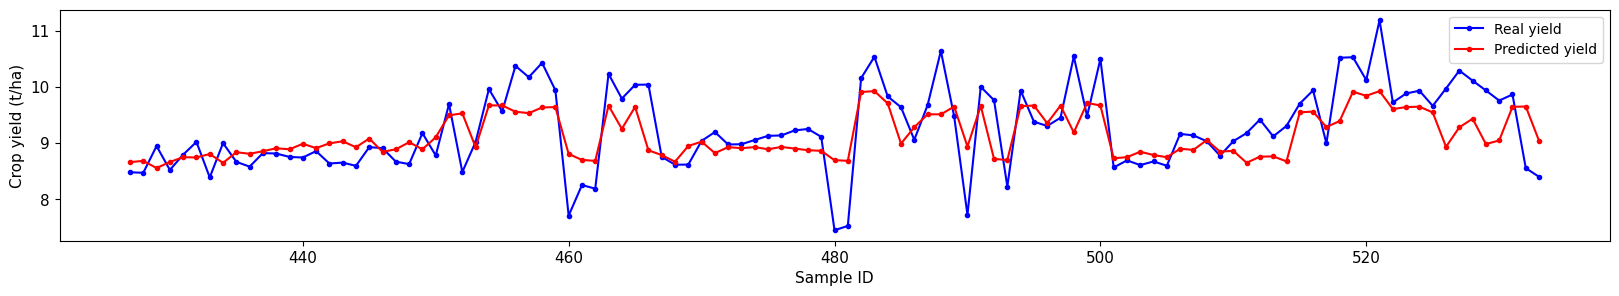

In [26]:
# plot real vs predicted yield
plt.figure(figsize=(20,3))
plt.plot(df_test['yield'], linestyle='-', marker='.', color='blue', label='Real yield')
plt.plot(df_test['predicted_crisp_yield'], linestyle='-', marker='.', color='red', label='Predicted yield')
plt.xlabel('Sample ID', fontsize=11)
plt.ylabel('Crop yield (t/ha)', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend()
plt.show()